In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

from scipy.optimize import root_scalar

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

-------
## Variation in GAIA->DECam transformation

In [24]:
sweep_list = ['sweep-180p010-190p015.fits', 'sweep-190p010-200p015.fits', 'sweep-180p015-190p020.fits', 'sweep-190p015-200p020.fits', 'sweep-160p010-170p015.fits', 'sweep-170p010-180p015.fits', 'sweep-160p015-170p020.fits', 'sweep-170p015-180p020.fits']

cat = []
for sweep_fn in sweep_list:
    tmp = fitsio.read('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/'+sweep_fn, columns=['GAIA_PHOT_G_MEAN_MAG'])
    idx = np.where(tmp['GAIA_PHOT_G_MEAN_MAG']!=0)[0]
    tmp = fitsio.read('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/'+sweep_fn, rows=idx)
    tmp = Table(tmp)
    cat.append(tmp)
    
cat = vstack(cat)
print(len(cat))

1093771


In [25]:
mask = (cat['RA']<197.5) | (cat['DEC']<17)
cat = cat[mask]

ramin, ramax, decmin, decmax = 182, 183, 18.4, 18.8
mask = (cat['RA']>ramin) & (cat['RA']<ramax) & (cat['DEC']>decmin) & (cat['DEC']<decmax)
cat = cat[~mask]

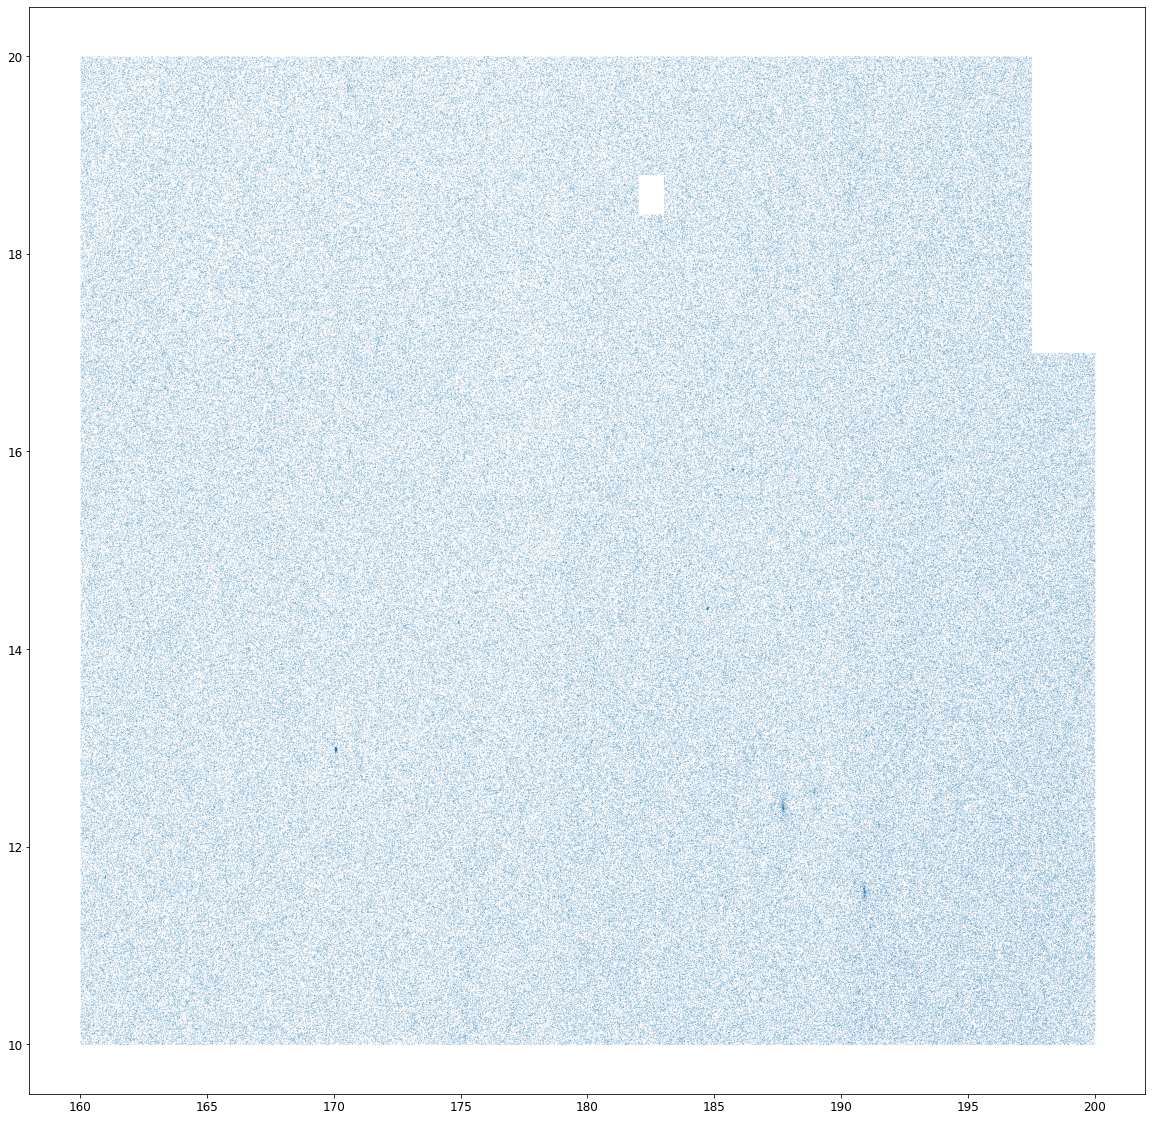

In [26]:
plt.figure(figsize=(20, 20))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.1)
plt.show()

BP-RP 2-sigma lower bound: 0.635
BP-RP 2-sigma upper bound: 2.768
BP-RP 3-sigma lower bound: 0.009
BP-RP 3-sigma upper bound: 3.393


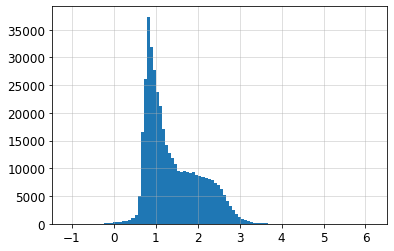

In [27]:
mask = (cat['GAIA_PHOT_G_MEAN_MAG']>7) & (cat['GAIA_PHOT_G_MEAN_MAG']<19)
mask &= np.isfinite(cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])
cat = cat[mask]

bp_rp_2sigma_min = np.percentile((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG']), 2.5)
bp_rp_2sigma_max = np.percentile((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG']), 97.5)
print('BP-RP 2-sigma lower bound: {:.3f}'.format(bp_rp_2sigma_min))
print('BP-RP 2-sigma upper bound: {:.3f}'.format(bp_rp_2sigma_max))

bp_rp_3sigma_min = np.percentile((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG']), 0.27/2)
bp_rp_3sigma_max = np.percentile((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG']), 100-0.27/2)
print('BP-RP 3-sigma lower bound: {:.3f}'.format(bp_rp_3sigma_min))
print('BP-RP 3-sigma upper bound: {:.3f}'.format(bp_rp_3sigma_max))

plt.hist((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG']), 100)
plt.grid(alpha=0.5)
plt.show()

In [28]:
mask = cat['MASKBITS']==0
print(np.sum(mask))
cat = cat[mask]

mask = cat['TYPE']=='PSF'
print(np.sum(mask))
cat = cat[mask]

mask = cat['FRACFLUX_R']<0.1
print(np.sum(mask))
cat = cat[mask]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1'])
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2'])

278872
275842
273964


In [35]:
mask = (cat['GAIA_PHOT_G_MEAN_MAG']>16) & ((cat['GAIA_PHOT_G_MEAN_MAG']<18.5))

g_2sigma_min, g_2sigma_max, g_3sigma_min, g_3sigma_max = np.percentile((cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], [2.5, 97.5, 0.27/2, 100-0.27])
print('DECaLS_G - GAIA_G range: {:.2f}, {:.2f} ({:.2f}, {:.2f})'.format(g_2sigma_min, g_2sigma_max, g_3sigma_min, g_3sigma_max))

r_2sigma_min, r_2sigma_max, r_3sigma_min, r_3sigma_max = np.percentile((cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], [2.5, 97.5, 0.27/2, 100-0.27])
print('DECaLS_R - GAIA_G range: {:.2f}, {:.2f} ({:.2f}, {:.2f})'.format(r_2sigma_min, r_2sigma_max, r_3sigma_min, r_3sigma_max))

z_2sigma_min, z_2sigma_max, z_3sigma_min, z_3sigma_max = np.percentile((cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], [2.5, 97.5, 0.27/2, 100-0.27])
print('DECaLS_Z - GAIA_G range: {:.2f}, {:.2f} ({:.2f}, {:.2f})'.format(z_2sigma_min, z_2sigma_max, z_3sigma_min, z_3sigma_max))

DECaLS_G - GAIA_G range: 0.22, 1.91 (-0.12, 2.28)
DECaLS_R - GAIA_G range: -0.17, 0.41 (-0.30, 0.67)
DECaLS_Z - GAIA_G range: -1.57, -0.10 (-1.86, 0.31)


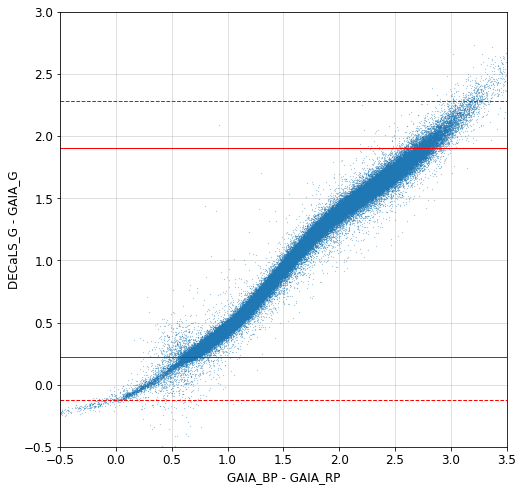

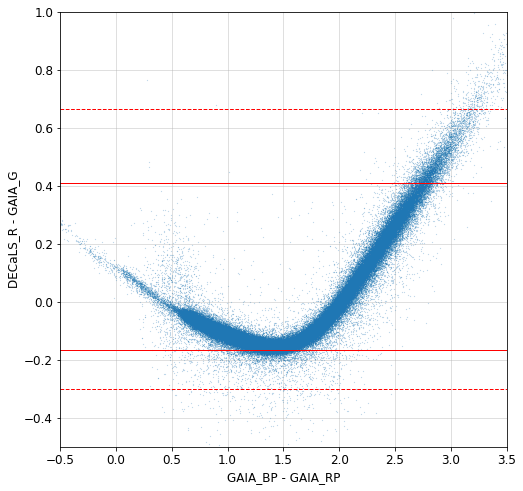

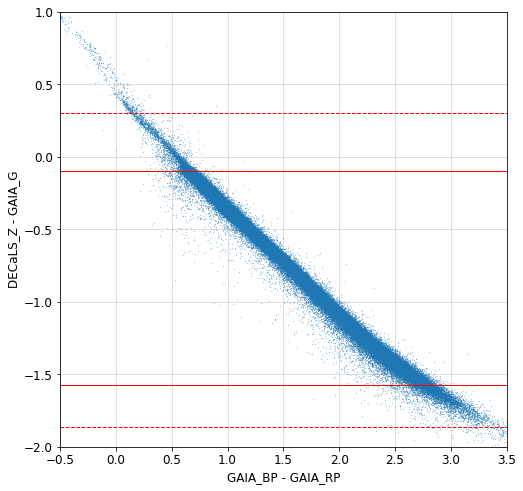

In [36]:
plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.3)
plt.axhline(g_2sigma_min, lw=1, color='r')
plt.axhline(g_2sigma_max, lw=1, color='r')
plt.axhline(g_3sigma_min, lw=1, ls='--', color='r')
plt.axhline(g_3sigma_max, lw=1, ls='--', color='r')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_G - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 3.])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.2)
plt.axhline(r_2sigma_min, lw=1, color='r')
plt.axhline(r_2sigma_max, lw=1, color='r')
plt.axhline(r_3sigma_min, lw=1, ls='--', color='r')
plt.axhline(r_3sigma_max, lw=1, ls='--', color='r')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_R - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 1])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.3)
plt.axhline(z_2sigma_min, lw=1, color='r')
plt.axhline(z_2sigma_max, lw=1, color='r')
plt.axhline(z_3sigma_min, lw=1, ls='--', color='r')
plt.axhline(z_3sigma_max, lw=1, ls='--', color='r')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_Z - GAIA_G')
plt.axis([-0.5, 3.5, -2, 1.])
plt.grid(alpha=0.5)
plt.show()

-------
## Variation in Moffat parameters

In [9]:
surveyccd = fitsio.read('/Users/rongpu/Documents/Data/desi_misc/survey-ccds-decam-dr9-cut.fits.gz', columns=['expnum', 'ccd_cuts'])
surveyccd = Table(surveyccd)
print(len(surveyccd))

mask = surveyccd['ccd_cuts']==0
surveyccd = surveyccd[mask]
print(len(surveyccd))

6388338
4881022


In [10]:
moffat_params = Table.read('/Users/rongpu/Documents/Data/desi_misc/bright_star_profiles/survey-ccds-decam-dr9-cut-psfex-moffat-params-subsample.fits')
print(len(moffat_params))

mask = np.in1d(moffat_params['expnum'], np.unique(surveyccd['expnum']))
moffat_params = moffat_params[mask]
print(len(moffat_params))

120616
91802


In [11]:
moffat_params[:3]

expnum,ccdname,psf_patch_ver,moffat_alpha,moffat_beta,sum_diff,fit_original,failure,filter
int64,bytes3,bytes7,float64,float64,float64,float64,bool,bytes1
229623,S29,d683d99,1.28679689596447,2.937979458229918,0.000707554048858583,1.0000000240511808,False,g
229623,S30,d683d99,1.2933592782928862,2.943162756443126,0.000604121305514127,1.0000002456031383,False,g
229623,S31,d683d99,1.277093991086473,2.9179050170630583,0.00022803609317634255,1.0000000276525645,False,g


In [12]:
np.unique(moffat_params['filter'], return_counts=True)

(<Column name='filter' dtype='bytes1' length=3>
 g
 r
 z, array([31131, 29932, 30739]))

In [13]:
medians = {}
for band in ['g', 'r', 'z']:
    mask = moffat_params['filter']==band
    medians[band+'_alpha'] = np.median(moffat_params['moffat_alpha'][mask])
    medians[band+'_beta'] = np.median(moffat_params['moffat_beta'][mask])
    print(band+' band:')
    print('median alpha = {:.3f}'.format(medians[band+'_alpha']))
    print('median beta = {:.3f}'.format(medians[band+'_beta']))

g band:
median alpha = 0.861
median beta = 2.480
r band:
median alpha = 0.667
median beta = 2.229
z band:
median alpha = 0.514
median beta = 1.999


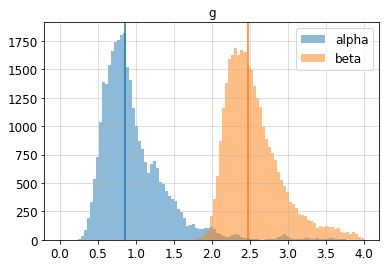

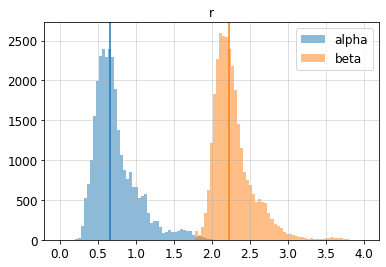

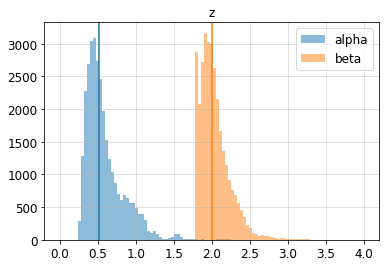

In [14]:
for band in ['g', 'r', 'z']:
    mask = moffat_params['filter']==band
    plt.hist(moffat_params['moffat_alpha'][mask], 101, alpha=0.5, range=(0, 4), label='alpha')
    plt.hist(moffat_params['moffat_beta'][mask], 101, alpha=0.5, range=(0, 4), label='beta')
    plt.axvline(medians[band+'_alpha'], lw=1.5, color='C0')
    plt.axvline(medians[band+'_beta'], lw=1.5, color='C1')
    plt.title(band)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()